<a href="https://colab.research.google.com/github/papaya147/predictive-analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/files/rpr76f381b

--2024-11-06 05:04:24--  https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/files/rpr76f381b
Resolving ora.ox.ac.uk (ora.ox.ac.uk)... 129.67.246.216
Connecting to ora.ox.ac.uk (ora.ox.ac.uk)|129.67.246.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘rpr76f381b’

rpr76f381b              [ <=>                ]   6.43G  19.7MB/s    in 6m 31s  

2024-11-06 05:10:56 (16.8 MB/s) - ‘rpr76f381b’ saved [6902652480]



In [51]:
!unzip rpr76f381b -d data >> /dev/null

replace data/capture24/P023.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

In [ ]:
def extract_features(xyz, sample_rate=100):
    ''' Extract commonly used HAR time-series features. xyz is a window of shape (N,3) '''

    feats = {}

    x, y, z = xyz.T

    feats['xmin'], feats['xq25'], feats['xmed'], feats['xq75'], feats['xmax'] = np.quantile(
        x, (0, .25, .5, .75, 1))
    feats['ymin'], feats['yq25'], feats['ymed'], feats['yq75'], feats['ymax'] = np.quantile(
        y, (0, .25, .5, .75, 1))
    feats['zmin'], feats['zq25'], feats['zmed'], feats['zq75'], feats['zmax'] = np.quantile(
        z, (0, .25, .5, .75, 1))

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        # xy, xy, zx correlation
        feats['xycorr'] = np.nan_to_num(np.corrcoef(x, y)[0, 1])
        feats['yzcorr'] = np.nan_to_num(np.corrcoef(y, z)[0, 1])
        feats['zxcorr'] = np.nan_to_num(np.corrcoef(z, x)[0, 1])

    v = np.linalg.norm(xyz, axis=1)

    feats['min'], feats['q25'], feats['med'], feats['q75'], feats['max'] = np.quantile(
        v, (0, .25, .5, .75, 1))

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        # 1s autocorrelation
        feats['corr1s'] = np.nan_to_num(np.corrcoef(
            v[:-sample_rate], v[sample_rate:]))[0, 1]

    # Angular features
    feats.update(angular_features(xyz, sample_rate))

    # Spectral features
    feats.update(spectral_features(v, sample_rate))

    # Peak features
    feats.update(peak_features(v, sample_rate))

    return feats


def spectral_features(v, sample_rate):
    """ Spectral entropy, 1st & 2nd dominant frequencies """

    feats = {}

    # Spectrum using Welch's method with 3s segment length
    # First run without detrending to get the true spectrum
    freqs, powers = signal.welch(v, fs=sample_rate,
                                 nperseg=3 * sample_rate,
                                 noverlap=2 * sample_rate,
                                 detrend=False,
                                 average='median')

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        feats['pentropy'] = np.nan_to_num(stats.entropy(powers + 1e-16))

    # Spectrum using Welch's method with 3s segment length
    # Now do detrend to focus on the relevant freqs
    freqs, powers = signal.welch(v, fs=sample_rate,
                                 nperseg=3 * sample_rate,
                                 noverlap=2 * sample_rate,
                                 detrend='constant',
                                 average='median')

    peaks, _ = signal.find_peaks(powers)
    peak_powers = powers[peaks]
    peak_freqs = freqs[peaks]
    peak_ranks = np.argsort(peak_powers)[::-1]
    if len(peaks) >= 2:
        feats['f1'] = peak_freqs[peak_ranks[0]]
        feats['f2'] = peak_freqs[peak_ranks[1]]
        feats['p1'] = peak_powers[peak_ranks[0]]
        feats['p2'] = peak_powers[peak_ranks[1]]
    elif len(peaks) == 1:
        feats['f1'] = feats['f2'] = peak_freqs[peak_ranks[0]]
        feats['p1'] = feats['p2'] = peak_powers[peak_ranks[0]]
    else:
        feats['f1'] = feats['f2'] = 0
        feats['p1'] = feats['p2'] = 0

    return feats


def peak_features(v, sample_rate):
    """ Features of the signal peaks. A proxy to step counts. """

    feats = {}
    u = butterfilt(v, (.6, 5), fs=sample_rate)
    peaks, peak_props = signal.find_peaks(
        u, distance=0.2 * sample_rate, prominence=0.25)
    feats['numPeaks'] = len(peaks)
    if len(peak_props['prominences']) > 0:
        feats['peakPromin'] = np.median(peak_props['prominences'])
    else:
        feats['peakPromin'] = 0

    return feats


def angular_features(xyz, sample_rate):
    """ Roll, pitch, yaw.
    Hip and Wrist Accelerometer Algorithms for Free-Living Behavior
    Classification, Ellis et al.
    """

    feats = {}

    # Raw angles
    x, y, z = xyz.T

    roll = np.arctan2(y, z)
    pitch = np.arctan2(x, z)
    yaw = np.arctan2(y, x)

    feats['avgroll'] = np.mean(roll)
    feats['avgpitch'] = np.mean(pitch)
    feats['avgyaw'] = np.mean(yaw)
    feats['sdroll'] = np.std(roll)
    feats['sdpitch'] = np.std(pitch)
    feats['sdyaw'] = np.std(yaw)

    # Gravity angles
    xyz = butterfilt(xyz, 0.5, fs=sample_rate)

    x, y, z = xyz.T

    roll = np.arctan2(y, z)
    pitch = np.arctan2(x, z)
    yaw = np.arctan2(y, x)

    feats['rollg'] = np.mean(roll)
    feats['pitchg'] = np.mean(pitch)
    feats['yawg'] = np.mean(yaw)

    return feats


def butterfilt(x, cutoffs, fs, order=10, axis=0):
    nyq = 0.5 * fs
    if isinstance(cutoffs, tuple):
        hicut, lowcut = cutoffs
        if hicut > 0:
            btype = 'bandpass'
            Wn = (hicut / nyq, lowcut / nyq)
        else:
            btype = 'low'
            Wn = lowcut / nyq
    else:
        btype = 'low'
        Wn = cutoffs / nyq
    sos = signal.butter(order, Wn, btype=btype, analog=False, output='sos')
    y = signal.sosfiltfilt(sos, x, axis=axis)
    return y


def get_feature_names():
    """ Hacky way to get the list of feature names """

    feats = extract_features(np.zeros((1000, 3)), 100)
    return list(feats.keys())

In [23]:
data = pd.read_csv(
    "data/capture24/P001.csv.gz", compression="gzip",
    index_col="time", parse_dates=["time"],
    dtype={"x": "f4", "y": "f4", "z": "f4", "annotation": "string"}
    )
data

,x,y,z,annotation
time,,,,
2016-11-13 02:18:00.000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.010,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.020,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.030,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.040,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
...,...,...,...,...
2016-11-14 06:07:59.960,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95
2016-11-14 06:07:59.970,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
2016-11-14 06:07:59.980,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95


In [24]:
annot = pd.read_csv("data/capture24/annotation-label-dictionary.csv", index_col="annotation")
annot

,label:WillettsSpecific2018,label:WillettsMET2018,label:DohertySpecific2018,label:Willetts2018,label:Doherty2018,label:Walmsley2020
annotation,,,,,,
7030 sleeping;MET 0.95,sleep,sleep,sleep,sleep,sleep,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,household-chores,sitstand+activity,tasks-moderate,mixed,moderate,light
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sitting,sitstand+lowactivity,sedentary-non-screen,sit-stand,sedentary,sedentary
...,...,...,...,...,...,...
transportation;walking;17250 walking as the single means to a destination not to work or class;MET 3.0,mixed-activity,walking,walking,mixed,walking,moderate-vigorous
transportation;walking;17270 walking as the single means to work or class (not from);MET 3.5,walking,walking,walking,walking,walking,moderate-vigorous
transportation;public transportation;16016 riding in a bus or train;MET 1.3,vehicle,vehicle,vehicle,vehicle,sedentary,sedentary


In [55]:
# using Willetts2018
annot["label:Willetts2018"]

,label:Willetts2018
annotation,
7030 sleeping;MET 0.95,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sit-stand
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,mixed
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sit-stand
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sit-stand
...,...
transportation;walking;17250 walking as the single means to a destination not to work or class;MET 3.0,mixed
transportation;walking;17270 walking as the single means to work or class (not from);MET 3.5,walking
transportation;public transportation;16016 riding in a bus or train;MET 1.3,vehicle


In [56]:
# mapping data to low dimension annotation
data["label"] = annot["label:Willetts2018"].reindex(data["annotation"]).to_numpy()
data

,x,y,z,annotation,label
time,,,,,
2016-11-13 02:18:00.000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.010,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.020,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.030,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.040,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
...,...,...,...,...,...
2016-11-14 06:07:59.960,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95,sleep
2016-11-14 06:07:59.970,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,sleep
2016-11-14 06:07:59.980,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,sleep


In [57]:
data.label.unique()

array(['sleep', nan, 'mixed', 'walking', 'vehicle', 'sit-stand'],
      dtype=object)

In [58]:
def window(data, size = "10s"):
  X, Y = [], []
  for time, d in data.resample(size, origin='start'):
      if d.isna().any().any() or len(d) != 1000:
          continue

      x = d[["x", "y", "z"]].to_numpy()
      y = d["label"].mode(dropna=False).item()

      X.append(x)
      Y.append(y)

  X = np.stack(X)
  Y = np.stack(Y)

  return X, Y

In [59]:
# creating the windows
X, Y = window(data)

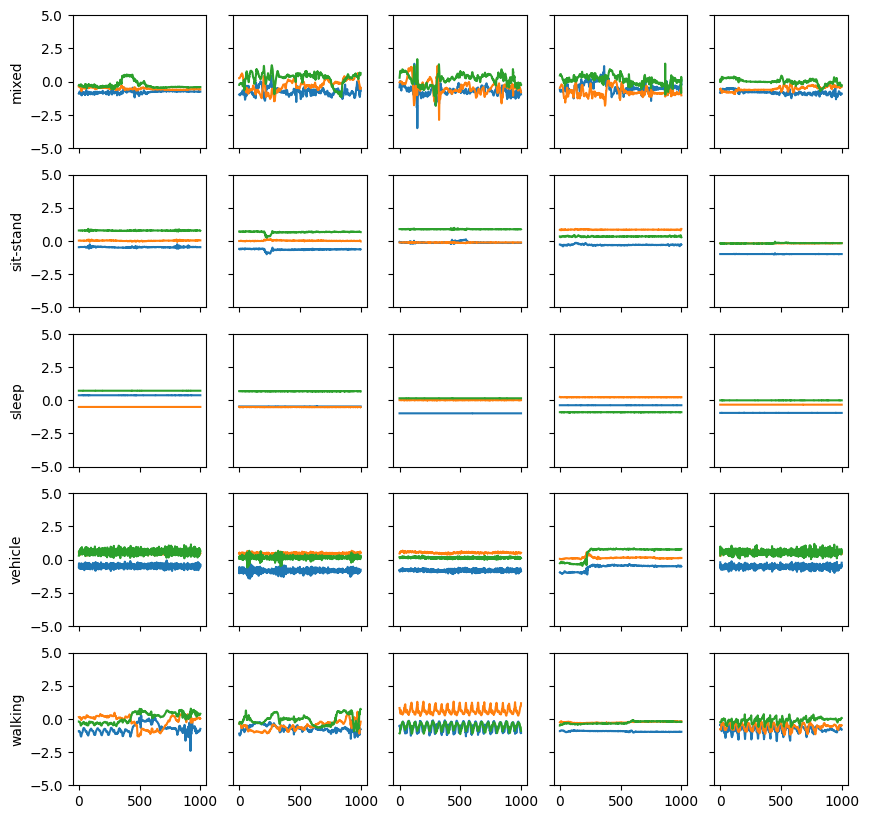

In [61]:
# plotting the activities
plots = 5
unique_labels = np.unique(Y)
fig, ax = plt.subplots(len(unique_labels), plots, sharex = True, sharey = True, figsize = (10, 10))
for label, row in zip(unique_labels, ax):
    i = np.random.choice(np.where(Y == label)[0], size = plots)
    row[0].set_ylabel(label)
    for feature, x in zip(X[i], row):
        x.plot(feature)
        x.set_ylim(-5, 5)
fig.show()

In [63]:
# training model to predict activity
Xf = pd.DataFrame([features.extract_features(x) for x in X])
Yf = pd.Series(Y)
Xf

AttributeError: module 'features' has no attribute 'extract_features'